<h1>Session 5. Sample solution of Homework 2 </h1>

# Describing data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.api import qqplot
from statsmodels.stats.diagnostic import het_breuschpagan #for Breusch-Pagan test test
from statsmodels.formula.api import ols #for linear regression
import seaborn as sns #for heatmap
from scipy import stats
import statsmodels.tools as sm
from statsmodels.stats.diagnostic import linear_rainbow #linearity test
from scipy.stats import shapiro #for checking normality
from statsmodels.stats.outliers_influence import variance_inflation_factor #for checking Multicolinearity
from statsmodels.regression.linear_model import OLS #another function for running linear regression

In [2]:
data=pd.read_excel("Student_data.xlsx")

In [3]:
data.head()

,StudentID,school2,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,Final_Grade
0,1,GP,F,18,U,GT3,A,4,4,at_home,...,no,no,4,3,4,1,1,3,6,6
1,2,GP,F,17,U,GT3,T,1,1,at_home,...,yes,no,5,3,3,1,1,3,4,6
2,3,GP,F,15,U,LE3,T,1,1,at_home,...,yes,no,4,3,2,2,3,3,10,10
3,4,GP,F,15,U,GT3,T,4,2,health,...,yes,yes,3,2,2,1,1,5,2,15
4,5,GP,F,16,U,GT3,T,3,3,other,...,no,no,4,3,2,1,2,5,4,10


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 32 columns):
StudentID      395 non-null int64
school2        395 non-null object
sex            395 non-null object
age            395 non-null int64
address        395 non-null object
famsize        395 non-null object
Pstatus        395 non-null object
Medu           395 non-null int64
Fedu           395 non-null int64
Mjob           395 non-null object
Fjob           395 non-null object
reason         395 non-null object
guardian       395 non-null object
traveltime     395 non-null int64
studytime      395 non-null int64
failures       395 non-null int64
schoolsup      395 non-null object
famsup         395 non-null object
paid           395 non-null object
activities     395 non-null object
nursery        395 non-null object
higher         395 non-null object
internet       395 non-null object
romantic       395 non-null object
famrel         395 non-null int64
freetime       395 non-null 

<b>Ther are no missing values in the data. StudentID does not provide any meaningful information, we we'll drop it.</b> 

In [5]:
data.drop("StudentID",axis=1,inplace=True)

Let's check whether there is a variable with 0 variance. If there is any, we'll drop it.

In [6]:
data.var()==0

age            False
Medu           False
Fedu           False
traveltime     False
studytime      False
failures       False
famrel         False
freetime       False
goout          False
Dalc           False
Walc           False
health         False
absences       False
Final_Grade    False
dtype: bool

<b> There is no numeric variable with 0 variance.</b>

In [7]:
for i in data.select_dtypes(include="object").columns:
    print(i,"\n",data[i].value_counts(),"\n","---------------------")

school2 
 GP    349
MS     46
Name: school2, dtype: int64 
 ---------------------
sex 
 F    208
M    187
Name: sex, dtype: int64 
 ---------------------
address 
 U    307
R     88
Name: address, dtype: int64 
 ---------------------
famsize 
 GT3    281
LE3    114
Name: famsize, dtype: int64 
 ---------------------
Pstatus 
 T    354
A     41
Name: Pstatus, dtype: int64 
 ---------------------
Mjob 
 other       141
services    103
at_home      59
teacher      58
health       34
Name: Mjob, dtype: int64 
 ---------------------
Fjob 
 other       217
services    111
teacher      29
at_home      20
health       18
Name: Fjob, dtype: int64 
 ---------------------
reason 
 course        145
home          109
reputation    105
other          36
Name: reason, dtype: int64 
 ---------------------
guardian 
 mother    273
father     90
other      32
Name: guardian, dtype: int64 
 ---------------------
schoolsup 
 no     344
yes     51
Name: schoolsup, dtype: int64 
 ---------------------
fams

<b> There is no string variable with only 1 category. So, we'll not drop from the data any string variable.</b>

<b> Let's visualise the distribution of dependent variable - Final_Grade. </b>

C:\Users\HP\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


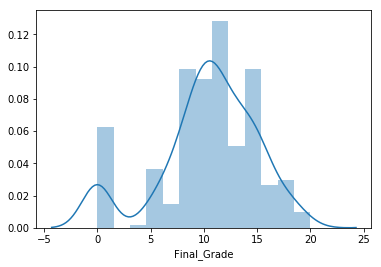

In [8]:
sns.distplot(data.Final_Grade)
plt.show()

# Question 1: Choose all or several variables which you think can affect the student final grade.

<b> Let's visualize the relationship between Final_Grade and other variables to get insights which variable we can choose to include in the first model.</b>

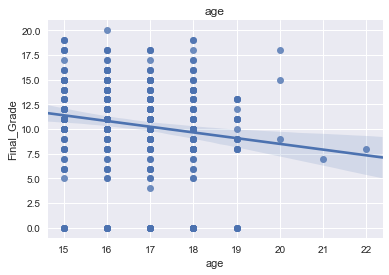

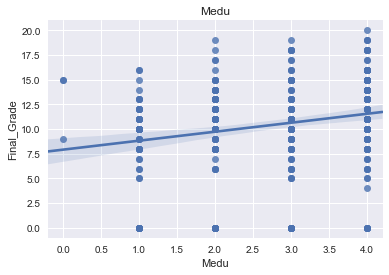

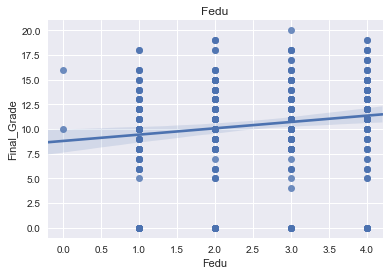

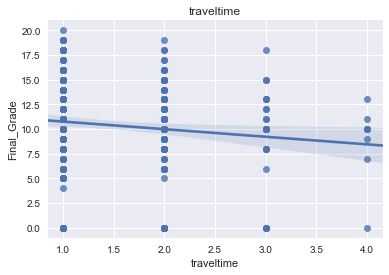

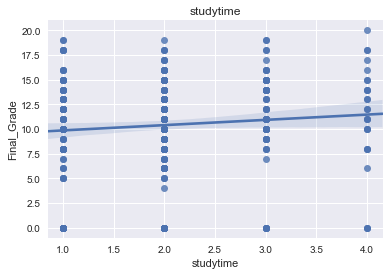

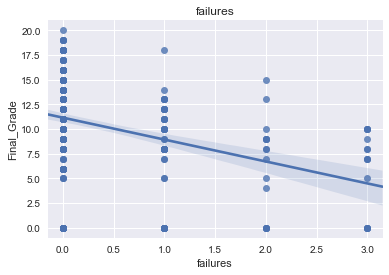

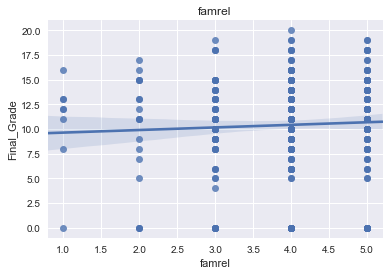

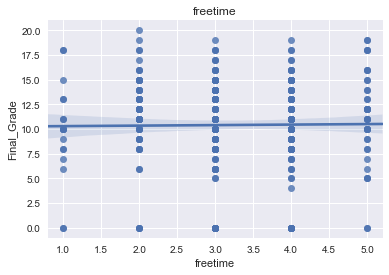

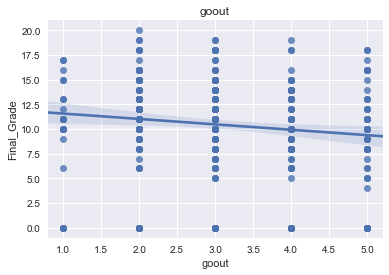

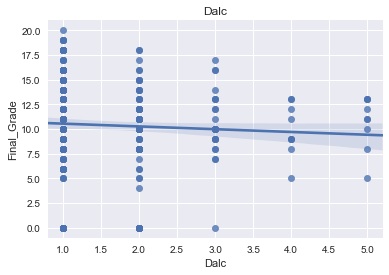

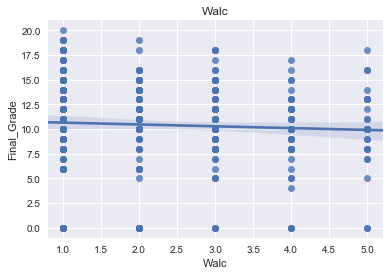

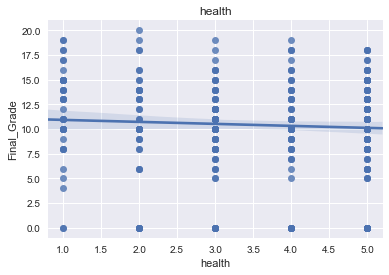

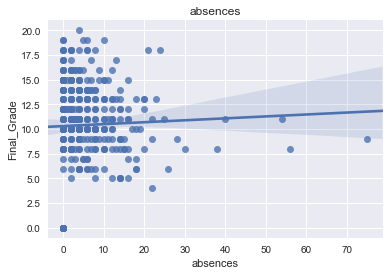

In [9]:
for i in data.select_dtypes(exclude="object").columns[:-1]:
    sns.set()
    sns.regplot(i,"Final_Grade", data=data)
    plt.title(i)
    plt.show()

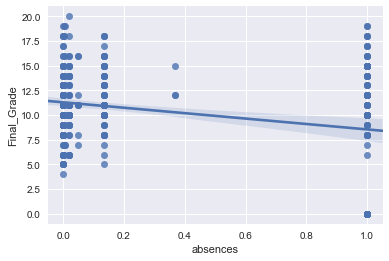

In [10]:
sns.regplot(np.exp(-data.absences),data.Final_Grade)
plt.show()

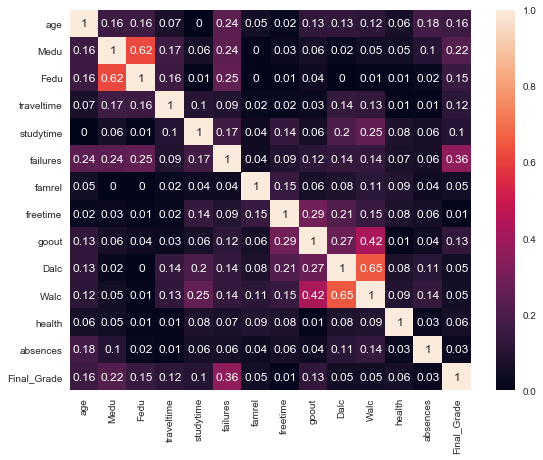

In [11]:
plt.figure(figsize=(9,7))
sns.heatmap(data.corr().abs().round(2),annot=True)
plt.show()

Based on the scatter plots and the correlation plot, I will include in the first model all the variables which have realtively strong relationship with Final_grade (see scatter plots above and correlation coefficients). Particularly, I have chosen the numeric variables which have correlation with final grade more than 10%. Further, I will add dummy variables to my initial model as well. Here are the numeric variables that will appear in the initial model:
- age,
- mother education (Medu),
- father education (Fedu),
- traveltime,
- failures,
- going out with friend (goout),
- absences, the corr coefficient for this variable is less than 10%, however to my personal opinion starting from some point the number of absences may affect students' performance. It can be seen from the scatter plot that there is non-linear relationship between final grade and absences, and this can be the reason for small corr coefficinet. And, as the relationship is not linear I will include exponential value of this variable(see, Final_Grade vs Exp(-absences) graph).

# Question 2: Estimate a linear regression model with OLS method to obtain the model parameters.
## Model 1_1

In [12]:
model1=ols(formula="Final_Grade~age+Medu+Fedu+traveltime+failures+goout+np.exp(-absences)",data=data)
results1=model1.fit()
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Final_Grade   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     16.96
Date:                Sun, 24 Feb 2019   Prob (F-statistic):           1.45e-19
Time:                        17:09:44   Log-Likelihood:                -1108.3
No. Observations:                 395   AIC:                             2233.
Df Residuals:                     387   BIC:                             2264.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            16.6776      2.951      5.651      0.000      10.875      22.480
age                  -0.2428      0.167     -1.451      0.147      -0.572       0.086
Medu                  0.5425      0.242      2.242      0.025       0.067       1.018
Fedu                 -0.0147      0.243     -0.060      0.952      -0.493       0.464
traveltime           -0.3777      0.298     -1.268      0.205      -0.963       0.208
failures             -1.7430      0.294     -5.933      0.000      -2.321      -1.165
goout                -0.5281      0.188     -2.808      0.005      -0.898      -0.158
np.exp(-absences)    -2.7850      0.470     -5.923      0.000      -3.709      -1.861
==============================================================================
Omnibus:                        4.554   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.103   Jarque-Bera (JB):                4.653
Skew:                          -0.256   Prob(JB):                       0.0977
Kurtosis:                       2.853   Cond. No.                         255.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Model1_1

<b>Before evaluating the model, first I will remove the most not-significant variable, which is "Fedu".</b>

In [13]:
model1_1=ols(formula="Final_Grade~age+Medu+traveltime+failures+goout+np.exp(-absences)",data=data)
results1_1=model1_1.fit()
results1_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Final_Grade   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     19.84
Date:                Sun, 24 Feb 2019   Prob (F-statistic):           3.10e-20
Time:                        17:09:45   Log-Likelihood:                -1108.3
No. Observations:                 395   AIC:                             2231.
Df Residuals:                     388   BIC:                             2259.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            16.6557      2.925      5.693      0.000      10.904      22.407
age                  -0.2423      0.167     -1.452      0.147      -0.570       0.086
Medu                  0.5340      0.196      2.724      0.007       0.149       0.919
traveltime           -0.3766      0.297     -1.269      0.205      -0.960       0.207
failures             -1.7407      0.291     -5.981      0.000      -2.313      -1.169
goout                -0.5286      0.188     -2.817      0.005      -0.898      -0.160
np.exp(-absences)    -2.7874      0.468     -5.958      0.000      -3.707      -1.868
==============================================================================
Omnibus:                        4.549   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.103   Jarque-Bera (JB):                4.647
Skew:                          -0.255   Prob(JB):                       0.0979
Kurtosis:                       2.853   Cond. No.                         250.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<b> After removing Fedu, R^2 adj increased, so it was a good decision. Now, let's evaluate the model we got.</b>

# Question 3: Evaluate the overall model and say whether assumptions are met or not.
# Question 4: Extend the model (using transformation, selection or shrinkage methods) to obtain a better model, if possible.

### Checking for Linearity and Equal variance

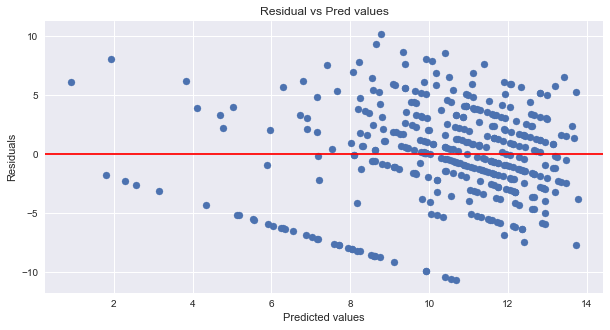

In [14]:
residuals1=results1_1.resid
pred_values1=results1_1.predict()
plt.figure(figsize=(10,5))
plt.scatter(pred_values1,residuals1)
plt.axhline(y=0, c="red")
plt.title("Residual vs Pred values")
plt.ylabel("Residuals")
plt.xlabel("Predicted values")
plt.show()

In [15]:
print("linearity test:",linear_rainbow(results1_1))
print("homoskedasticity test:",het_breuschpagan(residuals1,model1_1.exog))

linearity test: (0.9235430331902384, 0.7102627030861576)
homoskedasticity test: (85.44833688016158, 2.6654444122389125e-16, 17.850523116431365, 2.691522837461971e-18)


<b> We conclude that the model is linear, however it is not homoskedastic as the graph and test results show.</b>

### Normality

C:\Users\HP\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


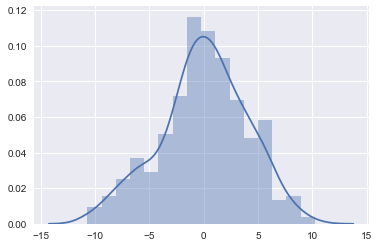

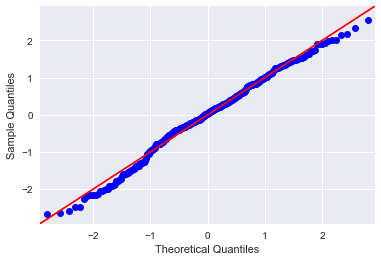

In [16]:
sns.distplot(residuals1)
qqplot(residuals1,fit=True,line='45')
plt.show()

In [17]:
shapiro(residuals1)

(0.9906020164489746, 0.012748480774462223)

<b>From the model summary, we observe that Jarque-Bera (JB) test results indicate the normal distribution of residuals. The same we can observe from the above presented distribution plot and qqplot. However, Shapiro-Wilk test shows that the assumption of normality is violated, this is because of different ways of calculations. Here, we will trust JB test and graphical respresentation, but having in mind the results of Shapiro-Wilk as well.</b>

### Multicollinearity

In [18]:
#adding exponential value of absences to the dataset 
#to be able to calculate correlation between all variables included in the model
data["exp_absences"]=np.exp(-data.absences)

In [19]:
#creatib list from X variables
X=['age','Medu','traveltime','failures','goout','exp_absences']

In [20]:
# Multicollinearity
#calculating vif using variance_inflation_factor() function from statsmodel
vif = [variance_inflation_factor(data[X].values, i) for i in range(0,len(X))]
for i in range(0,len(X)):
    print(X[i],":",vif[i])

age : 19.90652400765282
Medu : 7.38522774302993
traveltime : 5.4048102277944325
failures : 1.3292277260571557
goout : 9.241046005713246
exp_absences : 1.5369760172368516


<b>Age should be removed as it is highly correlated with other variables.</b>

<b>So, for Model1 two assumprtions (indepencdence and homoskedasticity) are violated.</b>

# Model1_2

<b>Let's remove 'age' to solve multicollinearity issue. Also, let's include some string variables as well. After checking for several variables, only sex improves the model. So, I'll keeep only sex.</b> 

In [21]:
model1_2=ols(formula="Final_Grade~Medu+traveltime+failures+goout+np.exp(-absences)+sex",data=data)
results1_2=model1_2.fit()
results1_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Final_Grade   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     20.84
Date:                Sun, 24 Feb 2019   Prob (F-statistic):           3.44e-21
Time:                        17:09:45   Log-Likelihood:                -1106.0
No. Observations:                 395   AIC:                             2226.
Df Residuals:                     388   BIC:                             2254.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            12.4381      0.947     13.139      0.000      10.577      14.299
sex[T.M]              1.0578      0.409      2.589      0.010       0.255       1.861
Medu                  0.5200      0.194      2.675      0.008       0.138       0.902
traveltime           -0.4428      0.296     -1.498      0.135      -1.024       0.139
failures             -1.8637      0.284     -6.564      0.000      -2.422      -1.305
goout                -0.5846      0.186     -3.145      0.002      -0.950      -0.219
np.exp(-absences)    -2.7248      0.464     -5.869      0.000      -3.638      -1.812
==============================================================================
Omnibus:                        4.275   Durbin-Watson:                   2.053
Prob(Omnibus):                  0.118   Jarque-Bera (JB):                4.361
Skew:                          -0.250   Prob(JB):                        0.113
Kurtosis:                       2.874   Cond. No.                         22.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<b> Removing 'age' and including sex has increased Adj. R-squared and R-squared. This means that we made a good decision to remove 'age' and include 'sex'. </b>

Let's check multicollinearity again without age. 

In [22]:
X_2=['Medu','traveltime','failures','goout','exp_absences']
vif = [variance_inflation_factor(data[X_2].values, i) for i in range(0,len(X_2))]
for i in range(0,len(X_2)):
    print(X_2[i],":",vif[i])

Medu : 5.1305020173809215
traveltime : 4.048265406362427
failures : 1.2898071549812458
goout : 6.45637435190194
exp_absences : 1.4733048513725588


<b>Conclusion</b>: After removing 'Fedu', 'age', including 'sex', and transforming 'absences' (taking exponencial value), we improved our model's performance (Model1_2).

# Model 2_1

<b>As it is shown above, I've already done backward selection and transformation of variables for the model in which not all variables were included. Now, I'd like to do backward selection for the model where initially all the variables are  included. I'd like to keep only 10 the most significant variables in the final model.</b>

In [23]:
data=pd.get_dummies(data,drop_first=True)

In [24]:
Y=data["Final_Grade"]
X=data.drop(["Final_Grade","absences"],axis=1)

In [25]:
X = sm.add_constant(X)

In [26]:
model2=OLS(Y,X)
results2=model2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Final_Grade   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     4.681
Date:                Sun, 24 Feb 2019   Prob (F-statistic):           1.07e-15
Time:                        17:09:46   Log-Likelihood:                -1079.2
No. Observations:                 395   AIC:                             2238.
Df Residuals:                     355   BIC:                             2398.
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                15.4991      4.269      3.631      0.000       7.104      23.894
age                  -0.3987      0.205     -1.947      0.052      -0.801       0.004
Medu                  0.4480      0.306      1.464      0.144      -0.154       1.050
Fedu                  0.0579      0.267      0.217      0.828      -0.466       0.582
traveltime           -0.1362      0.324     -0.420      0.675      -0.774       0.501
studytime             0.5262      0.273      1.929      0.055      -0.010       1.063
failures             -1.5744      0.319     -4.937      0.000      -2.202      -0.947
famrel                0.3625      0.236      1.537      0.125      -0.101       0.826
freetime              0.3503      0.227      1.545      0.123      -0.096       0.796
goout                -0.7108      0.215     -3.308      0.001      -1.133      -0.288
Dalc                 -0.3049      0.316     -0.965      0.335      -0.926       0.316
Walc                  0.1689      0.237      0.714      0.476      -0.296       0.634
health               -0.1291      0.154     -0.839      0.402      -0.432       0.173
exp_absences         -3.0026      0.484     -6.208      0.000      -3.954      -2.051
school2_MS            0.7433      0.749      0.993      0.322      -0.729       2.216
sex_M                 1.1064      0.474      2.333      0.020       0.174       2.039
address_U             0.7226      0.558      1.296      0.196      -0.374       1.819
famsize_LE3           0.5993      0.466      1.285      0.200      -0.318       1.517
Pstatus_T            -0.3571      0.688     -0.519      0.604      -1.710       0.996
Mjob_health           0.9740      1.064      0.916      0.361      -1.118       3.066
Mjob_other           -0.1645      0.682     -0.241      0.809      -1.505       1.176
Mjob_services         0.6668      0.762      0.876      0.382      -0.831       2.165
Mjob_teacher         -1.2642      0.990     -1.276      0.203      -3.212       0.684
Fjob_health           0.1444      1.372      0.105      0.916      -2.554       2.843
Fjob_other           -0.6807      0.977     -0.697      0.486      -2.601       1.240
Fjob_services        -0.3072      1.008     -0.305      0.761      -2.290       1.675
Fjob_teacher          1.0373      1.239      0.837      0.403      -1.399       3.474
reason_home           0.0697      0.524      0.133      0.894      -0.961       1.100
reason_other          0.4331      0.783      0.553      0.580      -1.106       1.972
reason_reputation     0.5668      0.548      1.034      0.302      -0.511       1.645
guardian_mother       0.0562      0.520      0.108      0.914      -0.966       1.079
guardian_other        0.4311      0.953      0.452      0.651      -1.444       2.306
schoolsup_yes        -1.6590      0.639     -2.597      0.010      -2.915

<b> When we include all the variables in the model, R-squared is higher compared to the first model but Adj. R-squared is less than R-squared as there are many non-significant variables. Let's ude backward stepwise selection to get better model.</b> 

# Model2_1

In [27]:
def eliminate_worst(X, Y):
    model = OLS(Y,X).fit()
    print("R squared =",model.rsquared)
    print("R sq. adj =",model.rsquared_adj)
    worst_covariate = model.pvalues[1:].idxmax()
    print("Should remove next ",worst_covariate, "with a p-value of", model.pvalues[worst_covariate])
    print("\n")
    X=X.drop(worst_covariate,axis=1)
    return X

while X.shape[1]>10:
    X = eliminate_worst(X,Y)

R squared = 0.33958561646629015
R sq. adj = 0.2670330503879389
Should remove next  Fjob_health with a p-value of 0.9162304199178454


R squared = 0.3395650054404603
R sq. adj = 0.2690691352346668
Should remove next  guardian_mother with a p-value of 0.9160337610953986


R squared = 0.339544354773616
R sq. adj = 0.2710937696941308
Should remove next  reason_home with a p-value of 0.8984264206020743


R squared = 0.33951416698499615
R sq. adj = 0.27309659718460466
Should remove next  nursery_yes with a p-value of 0.8275113758189294


R squared = 0.33942644507475905
R sq. adj = 0.2750251235639416
Should remove next  Fedu with a p-value of 0.83564677720452


R squared = 0.3393471315845976
R sq. adj = 0.27695213845647626
Should remove next  Mjob_other with a p-value of 0.7938963617530187


R squared = 0.33922168977371536
R sq. adj = 0.2788181323292074
Should remove next  traveltime with a p-value of 0.6444973542997323


R squared = 0.338831324645131
R sq. adj = 0.2803854748900044
Should rem

<b>We've kept 10 variables to include in the final model after doing backward elimination.</b>

In [28]:
model2_1=OLS(Y,X).fit()
model2_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Final_Grade   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     16.35
Date:                Sun, 24 Feb 2019   Prob (F-statistic):           8.97e-23
Time:                        17:09:46   Log-Likelihood:                -1097.2
No. Observations:                 395   AIC:                             2214.
Df Residuals:                     385   BIC:                             2254.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.9357      0.837     15.452      0.000      11.290      14.582
Medu              0.5422      0.198      2.738      0.006       0.153       0.931
failures         -1.8916      0.282     -6.705      0.000      -2.446      -1.337
goout            -0.6121      0.183     -3.354      0.001      -0.971      -0.253
exp_absences     -2.8138      0.458     -6.139      0.000      -3.715      -1.913
Mjob_health       1.7192      0.750      2.292      0.022       0.244       3.194
Mjob_services     1.3183      0.467      2.821      0.005       0.400       2.237
schoolsup_yes    -1.3709      0.601     -2.281      0.023      -2.552      -0.189
famsup_yes       -0.9523      0.419     -2.274      0.024      -1.776      -0.129
romantic_yes     -0.9187      0.426     -2.158      0.032      -1.756      -0.082
==============================================================================
Omnibus:                        7.476   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.024   Jarque-Bera (JB):                7.657
Skew:                          -0.339   Prob(JB):                       0.0217
Kurtosis:                       2.930   Cond. No.                         20.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<b>Conclusion</b>: All the variables that we've kept are statistically significant and explain 27.7% of the variance in Final_Grade. Adj. R-squared is quite near to R-squared. The model performs well compared to the Model1_2.

<b>Let's check diagnostics for this model as well.</b>

From, JB test it is already seen that there is a violation of normality. Let's check Shapiro Wilk test and graphical visualisation as well.

In [29]:
y_pred2=model2_1.predict()
resid2=model2_1.resid

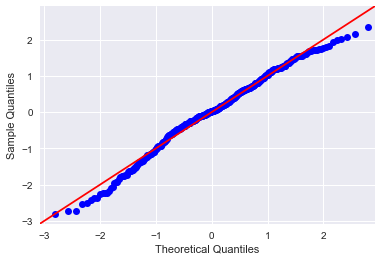

(0.9875208735466003, 0.0018180569168180227)


In [30]:
qqplot(resid2,fit=True,line='45')
plt.show()
print(shapiro(resid2))

<b>The assumption of normality is violated according to Shapiro Wilk test as well.</b>

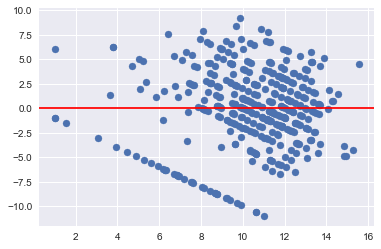

Linearity test (0.9593004110349781, 0.6137772853839649)
Heteroskedasticity test: (90.57884377305629, 1.2459513085592347e-15, 12.728292929165692, 9.113964195768932e-18)


In [31]:
plt.scatter(y_pred2,resid2)
plt.axhline(y=0,c="red")
plt.show()
print("Linearity test",linear_rainbow(model2_1))
print("Heteroskedasticity test:",het_breuschpagan(resid2,X))

<b>The model is linear. However, the variance of errors is not constant. </b>

In [32]:
vif2=[variance_inflation_factor(X.values,i) for i in range(0,X.drop("const",axis=1).shape[1])]

In [33]:
for i in range(0,X.drop("const",axis=1).shape[1]):
    print(X.drop("const",axis=1).columns[i],":",vif2[i])

Medu : 17.81324046700709
failures : 1.191085184850232
goout : 1.1157934740826447
exp_absences : 1.0468197932291718
Mjob_health : 1.030135852753502
Mjob_services : 1.1252839934965595
schoolsup_yes : 1.0698520011578674
famsup_yes : 1.032074561075709
romantic_yes : 1.0575519935036222


<b>There is Multicollinearity in the model. So, 3 assumptions are violated for Model2_1.</b>

<b> Even if in the Model2_1 R-squared is higher, I'll choose Model1_2 as for this model only equal variance assumption was violated.</b>

# Question 5: Interpret the results obtained from the final model.

- <b>R-squared and F-statistics</b>: As Prob (F-statistic) shows Model1_2 is statistically significant at 5% significance level, so there is at least one estimated coefficient (besides intercept) that is not null. R-squared is quite small number and it shows that 24.4% of the variance in Final Grades is explained by the variables included in the model.
- <b>Adj. R-squared</b>: As Model1_2 summary shows it's 23.2% and it is quite close to R-squared, which means that almost all variables included in the model have statistically significant relationship with Final Grades.
- <b>Statistically significant variables</b>: As p-values of t-statistics show, all variables included in the model are statistically significant at 5% sig. level (p<=0.05) except traveltime.
- <b>Coefficients (continous variable)</b>: Let's interpret for mother education (Medu). For each one level higher degree of mother's education, we will experience on average about 0.52 points increase in mean Final Grade.
- <b>Coefficients (categorical variable)</b>: Male students get higer grade on average by 1.05 points compared to their female classmates. 